In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

In [6]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import _src.lgssm as ssm
from jax import random

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [7]:
num_timesteps = 80
state_size = 4
obs_size = 2
mu0 = jnp.array([8, 5, 1, 0]).astype(float)
Sigma0 = jnp.eye(state_size) * 0.0001

step_std = 0.1
noise_std = 0.5

# transition_matrix = jnp.eye(state_size)
dt = 0.1
transition_matrix = jnp.array([
    [1, 0, dt, 0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
transition_noise = ssm.MultivariateNormal(jnp.zeros(state_size),
                                      step_std ** 2 * jnp.eye(state_size))

observation_matrix = jnp.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])
observation_noise = ssm.MultivariateNormal(jnp.zeros(obs_size),
                                       noise_std ** 2 * jnp.eye(obs_size))

initial_state_prior = ssm.MultivariateNormal(mu0, Sigma0)

In [8]:
kf = ssm.LinearGaussianStateSpaceModel(transition_matrix, transition_noise,
                                       observation_matrix, observation_noise,
                                       initial_state_prior)

In [19]:
%%time
n_samples = 1
key = random.PRNGKey(31415)
state_samples, obs_samples = kf.sample(seed=key, sample_shape=n_samples, num_timesteps=num_timesteps)

CPU times: user 1.89 s, sys: 76.6 ms, total: 1.97 s
Wall time: 1.89 s


### Forward Filter

In [20]:
%%time
log_probs, mu_hist, Sigma_hist, mu_cond_hist, Sigma_cond_hist = kf.forward_filter(obs_samples)

CPU times: user 1.21 s, sys: 48 ms, total: 1.26 s
Wall time: 1.24 s


### Backwards Filter

In [21]:
%%time

mu_hist_smooth, Sigma_hist_smooth = kf.backward_smoothing_pass(mu_hist, Sigma_hist, mu_cond_hist, Sigma_cond_hist)

CPU times: user 1.53 s, sys: 108 ms, total: 1.64 s
Wall time: 1.55 s


### (Alternative) Posterior Marginals

In [22]:
%%time

mu_hist_smooth, Sigma_hist_smooth = kf.posterior_marginals(obs_samples)

CPU times: user 2.29 s, sys: 50 ms, total: 2.34 s
Wall time: 2.33 s


### Log Probability

In [23]:
marginal_log_likelihood = jnp.sum(log_probs, axis=-1)

print(marginal_log_likelihood)

[-106.710464]


In [24]:
print(-marginal_log_likelihood.mean())

106.710464


## Viz

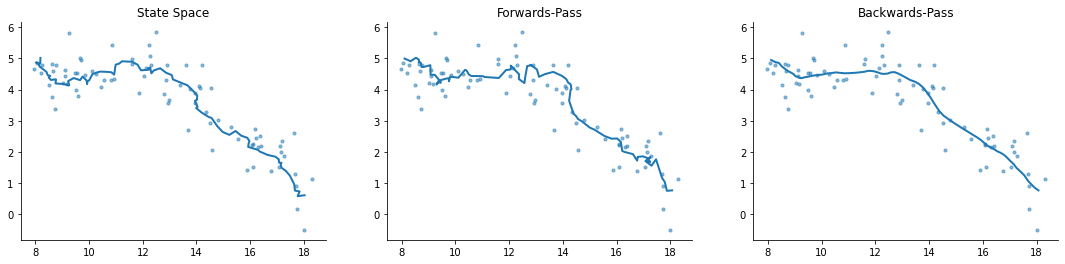

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(6.2 * 3, 4))
for n in range(n_samples):
    p = ax[0].plot(*state_samples[n, :, [0, 1]], linewidth=2)
    c = p[0].get_color()
    ax[1].plot(*mu_hist[n, :, [0, 1]], linewidth=2, c=c)
    ax[2].plot(*mu_hist_smooth[n, :, [0, 1]], linewidth=2, c=c)

    for axi in ax:
        axi.scatter(*obs_samples[n, :, [0, 1]], s=10, alpha=0.5, c=c)
    ax[0].set_title("State Space")
    ax[1].set_title("Forwards-Pass")
    ax[2].set_title("Backwards-Pass")

plt.show()